## Stardew Valley Planting Optimizer

### Imports and Helper Functions:

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

from crops import crops
from data import seasons
from data import ratios

In [2]:
def calculate_potential_harvests(days_remaining: int, days_to_grow_first_crop: int, days_to_regrow: int=0) -> int:
    """
    Calculates the maximum number of potential left in a given month, according to the crop specifications.
    
    :param days_remaining: int, Days remaining in the month.
    :param days_to_grow_first_crop: int, Days required for first harvest.
    :param days_to_regrow: int, Default=0, Days required for regrowing (if crop does not regrow, then it is not required)
    :return: int, number of harvests possible, given crop specifications.
    """
    harvests = 0
    if days_to_regrow == 0:
        days_to_regrow = days_to_grow_first_crop
    if days_remaining > days_to_grow_first_crop:
        harvests+=1
        days_remaining = days_remaining - days_to_grow_first_crop
    else: return 0

    while days_remaining > days_to_regrow:
        harvests+=1
        days_remaining = days_remaining - days_to_regrow
        
    return harvests


def test_calculate_potential_harvests() -> None:
    """
    Unit tests for calculate_potential_harvests()
    """
    assert calculate_potential_harvests(7,6,6) == 1
    assert calculate_potential_harvests(13,6,6) == 2
    assert calculate_potential_harvests(6,6,1) == 0
    assert calculate_potential_harvests(100,1,1) == 99
    
test_calculate_potential_harvests()


def find_optimal_knap_sack(W: int, wt: 'list[int]', val: 'list[int]', n: int) -> (int, list): 
    """
    :param W: int, Maximum weight of knap_sack (days remaining in month).
    :param wt: list[int], List of weights per item (days required per crop/value combo).
    :param val: list[int], List of values per item (value for crop/days required combo).
    :param n: int, length of either wts or val (could refactor out).
    :return: (int, list[ints]), maximum possible value, keeping weights under W, and also list of weights for reverse searching.
    """
    K = [[0 for w in range(W + 1)] 
            for i in range(n + 1)] 
              
    # Build table K[][] in bottom 
    # up manner 
    for i in range(n + 1): 
        for w in range(W + 1): 
            if i == 0 or w == 0: 
                K[i][w] = 0
            elif wt[i - 1] <= w: 
                K[i][w] = max(val[i - 1]  
                  + K[i - 1][w - wt[i - 1]], 
                               K[i - 1][w]) 
            else: 
                K[i][w] = K[i - 1][w] 
  
    # stores the result of Knapsack 
    res = K[n][W]
    temp_res = res
    keepers = []
    w = W 
    for i in range(n, 0, -1): 
        if res <= 0: 
            break
        # either the result comes from the 
        # top (K[i-1][w]) or from (val[i-1] 
        # + K[i-1] [w-wt[i-1]]) as in Knapsack 
        # table. If it comes from the latter 
        # one/ it means the item is included. 
        if res == K[i - 1][w]: 
            continue
        else: 
  
            # This item is included. 
            keepers.append(wt[i - 1])
              
            # Since this weight is included 
            # its value is deducted 
            res = res - val[i - 1] 
            w = w - wt[i - 1] 
    return (temp_res, keepers)

### Crop Class

In [3]:
import pandas as pd
class Crop:
    
    def __init__(self):
        """
        Example usage:
            # Initialize object
            c = Crop()
            c.deserialize(crop_config)
            c.build_profit_table(ratio)
            
            # Access profit table
            c.profit_table
        """
        pass
    
    def deserialize(self, crop_config: dict) -> None:
        """
        Constructs Crop object from crop_config json object.
        
        :param crop_config: Expects a crop_config similar to
        {'amaranth': {'name': 'Amaranth',
                      'url': 'http://stardewvalleywiki.com/Amaranth',
                      'img': 'amaranth.png',
                      'seeds': {'pierre': 70,
                       'joja': 87,
                       'special': 0,
                       'specialLoc': '',
                       'specialUrl': ''},
                      'growth': {'initial': 7, 'regrow': 0},
                      'produce': {'extra': 0,
                       'extraPerc': 0,
                       'rawN': 150,
                       'rawS': 187,
                       'rawG': 225,
                       'jar': 350,
                       'keg': 337,
                       'jarType': 'Pickles',
                       'kegType': 'Juice'}},
        :return: None
        """
        self.name = crop_config['name']
        self.growth = crop_config['growth']
        self.produce = crop_config['produce']
        self.seeds = crop_config['seeds']
        
    def get_earning_potential(self, ratios: dict, days_remaining_in_month: int) -> float:
        """
        Uses the farming ratios and days remaining in the month to calculate the earning potential
        through the end of the month. Trick: Can be used to also calculate profits in the event
        you wish to abandon a crop, i.e. days_remaining_in_month = 9 is the same profit value
        as starting on day 1 and abandoning crop after 9 days.
        
        :param ratios: dict, format similar to {'ratioN': 0.97, 'ratioS': 0.02, 'ratioG': 0.01}
        :param days_remaining_in_month: int, must be between 1-28 (inclusive).
        :return: None
        """
        assert days_remaining_in_month > 0
        assert days_remaining_in_month <= 28
        remaining_harvests = calculate_potential_harvests(days_remaining_in_month, self.growth['initial'], self.growth['regrow'])
        profit = 0
        profit += self.produce['rawN'] * ratios['ratioN'] * remaining_harvests;
        profit += self.produce['rawS'] * ratios['ratioS'] * remaining_harvests;
        profit += self.produce['rawG'] * ratios['ratioG'] * remaining_harvests;

        if (self.produce['extra'] > 0):
            profit += self.produce['rawN'] * self.produce['extraPerc'] * self.produce['extra'] * remaining_harvests
        return profit
#         if (options.skills.till) {
#             profit *= 1.1;
#             // console.log("Profit (After skills): " + profit);
#         }
#             else {
#                 var items = total_harvests;
#                 items += crop.produce.extraPerc * crop.produce.extra * total_harvests;

#                 switch (produce) {
#                     case 1: profit += items * crop.produce.jar; break;
#                     case 2: profit += items * crop.produce.keg; break;
#                 }

#                 if (options.skills.arti) {
#                     profit *= 1.4;
#                 }

    def build_profit_table(self, ratios: dict) -> None:
        """
        Iteratively builds a profit table with columns 'days_required' & 'earning_potential' for 
        every day in the month, based on the farming ratios. This table can be accessed as a field
        from the object.
        
        :param ratios: dict, format similar to {'ratioN': 0.97, 'ratioS': 0.02, 'ratioG': 0.01}
        :return: None
        """
        day_list= np.arange(1, 29)
        profit_table = pd.DataFrame()
        for day in day_list:
            profit_table = profit_table.append({
                'crop':self.name,
                'days_required':day,
                'earning_potential':self.get_earning_potential(ratio, days_remaining_in_month=day)
            }, [0])
        self.profit_table = profit_table.reset_index(drop=True)

### Example Usage

#### Intialize all crops for season (Spring), create crop_list for easier storage

In [4]:
spring = seasons[0]
crop_list = []
drop_crops = ['Coffee Bean', 'Strawberry']
ratio=ratios['none'][0]

for crop in spring['crops']:
    if crop['name'] not in drop_crops:
        c = Crop()
        c.deserialize(crop)
        c.build_profit_table(ratio)
        crop_list.append(c)

In [5]:
crop_list[0].profit_table.tail()

,crop,days_required,earning_potential
23,Rhubarb,24.0,222.2
24,Rhubarb,25.0,222.2
25,Rhubarb,26.0,222.2
26,Rhubarb,27.0,444.4
27,Rhubarb,28.0,444.4


#### Create new DF for analysis (append all crop profit tables into same DF)

In [6]:
df = pd.DataFrame()
for crop in crop_list:
    df = df.append(crop.profit_table)

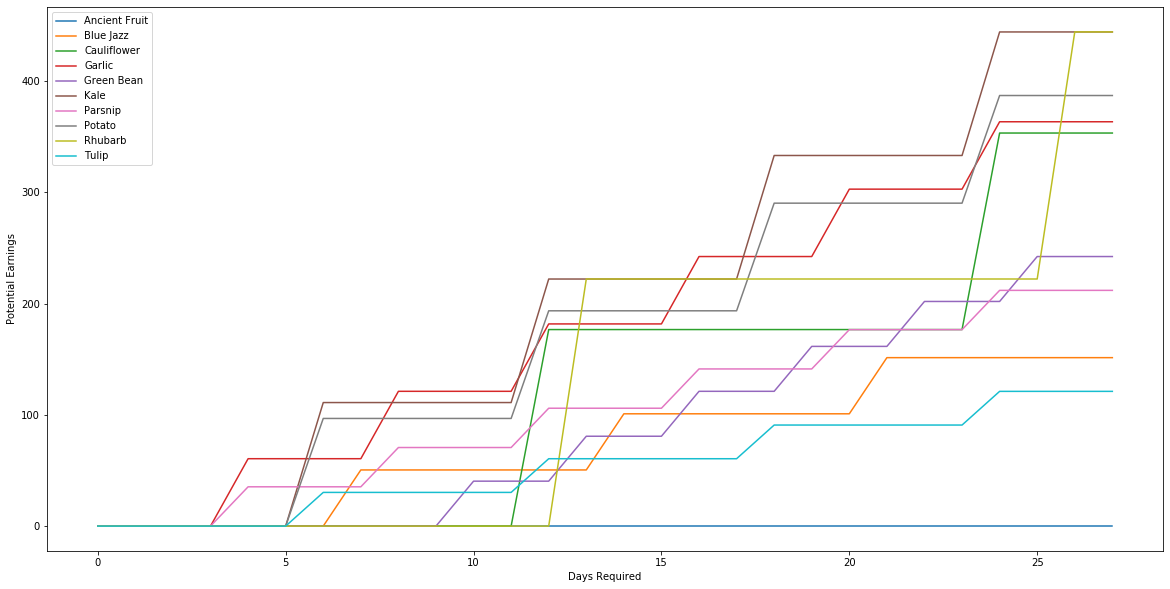

In [7]:
plt.figure(figsize=[20,10])
for crop in np.unique(df['crop']):
    plt_data = df[df['crop'] == crop].reset_index(drop=True)
    plt.plot(plt_data['earning_potential'], label=crop)
plt.legend()
plt.xlabel('Days Required')
plt.ylabel('Potential Earnings')
plt.show()


#### Find minimum days required for a given crop-earning potential pair

In [8]:
min_days_df = (df.groupby(['crop', 'earning_potential'])
                 .min()
                 .reset_index()
                 .sort_values('earning_potential')
                 .reset_index(drop=True))

#### Intialize Knap Sack Problem

In [9]:
item_weights = [int(x) for x in min_days_df['days_required']]
item_values = [int(x) for x in min_days_df['earning_potential']]
days_remaining_in_month = 28
n = len(item_values) 
      
res, keepers = find_optimal_knap_sack(days_remaining_in_month, item_weights, item_values, n) 

#### Reverse search the profit table based on optimal value (res)

In [10]:
search_space = min_days_df[[x in keepers for x in item_weights]]
search_space

,crop,earning_potential,days_required
16,Parsnip,70.66,9.0
18,Tulip,90.87,19.0
24,Garlic,121.20,9.0
39,Potato,290.40,19.0
41,Kale,333.27,19.0


#### Find combination of crops where sum(earning_potential) = res

In [11]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

optimal_crops = pd.concat([search_space.reindex(l).assign(grp=n) for n, l in 
                       enumerate(powerset(search_space.index)) 
                       if int(np.floor((search_space.loc[l, 'earning_potential'].sum())) == res)])

In [12]:
optimal_crops

,crop,earning_potential,days_required,grp
24,Garlic,121.20,9.0,14
41,Kale,333.27,19.0,14


In [13]:
print('Optimal earning potential: ${}'.format(res))

Optimal earning potential: $454
